In [3]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
#import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from pylab import rcParams
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [8]:
'''
datafolder = "./"
trainfile = datafolder+"train.csv"
testfile = datafolder+"test.csv"
validfile = datafolder+"valid.csv"if not os.path.exists(trainfile):
    !gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 
if not os.path.exists(validfile):
    !gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w 
if not os.path.exists(testfile):
    !gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF''' 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 188MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 126MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ep9

In [9]:
'''traindf = pd.read_csv(trainfile)
validdf = pd.read_csv(validfile)
testdf = pd.read_csv(testfile)'''

In [6]:
# Define split ratios
train_ratio = 0.7
test_ratio = 0.15
dev_ratio = 0.15

# Step 1: Load the CSV file using pandas
data = pd.read_csv("intent.csv")

# Step 2: Shuffle the data (optional)
data = data.sample(frac=1, random_state=42)

# Step 3: Split the data using scikit-learn
train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
test_data, dev_data = train_test_split(temp_data, train_size=test_ratio/(test_ratio+dev_ratio), random_state=42)


In [7]:
train_data.head()

,text,intent
40,How do I make my plants bushier?,plant_caretaking_advise
113,What are some plants that can withstand hot te...,plant_purchasing_advise
119,Can you recommend a plant that can add a tropi...,plant_purchasing_advise
27,What is the ideal watering schedule for a cactus?,plant_caretaking_advise
89,What are some plants that can thrive in a nort...,plant_purchasing_advise


In [10]:
train_data.shape

(95, 2)

In [11]:
trainfeatures=train_data.copy()
trainlabels=trainfeatures.pop("intent")

In [31]:
print(trainfeatures.shape)
print(trainlabels.shape)

(95, 1)
(95, 1)


In [13]:
print(trainlabels)

40     plant_caretaking_advise
113    plant_purchasing_advise
119    plant_purchasing_advise
27     plant_caretaking_advise
89     plant_purchasing_advise
                ...           
43     plant_caretaking_advise
32     plant_caretaking_advise
31     plant_caretaking_advise
93     plant_purchasing_advise
88     plant_purchasing_advise
Name: intent, Length: 95, dtype: object


In [14]:
trainfeatures=trainfeatures.values

In [15]:
from sklearn.preprocessing import LabelBinarizer

In [16]:
#one-hot-encodings of class-labels
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

In [17]:
trainlabels.shape

(95, 1)

In [18]:
#preprocess test and valid data same way as training data
testfeatures=test_data.copy()
testlabels=testfeatures.pop("intent")
validfeatures=dev_data.copy()
validlabels=validfeatures.pop("intent")

testfeatures=testfeatures.values
validfeatures=validfeatures.values

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

In [34]:
print(validlabels.shape)

(21, 1)


In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [21]:
#text input to numeric token ids
#preprocessing specific to each model

In [20]:
#load preprocessing model into a hub.KerasLayer to compose fine-tuned model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [21]:
#try on text 
trainfeatures[0]

array(['How do I make my plants bushier?'], dtype=object)

In [22]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')
#three outputs that BERT uses: input_words, input_mask and input_tyoe_ids (0 since single sentence input)
#input is truncate to 128 tokens --> customize?

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2129 2079 1045 2191 2026 4264 5747 3771 1029  102    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
#use BERT model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [24]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
#returns map with 3 important keys: 
#pooled_output --> represent each input sentence as a whole 
#sequence_output --> represent each input token in the context, shape: [batch_size, seq_length, H], contextual embedding
#encoder_output --> intermideiate activations of the L transformer blocks, tensor of shape [batch_size, seq_length, 1024] with outputs of ith Transfromer block for 0<=u<L, last value equal to sequence_output
#for fine-tuning using pooled_output

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.6221578  -0.11862625 -0.9995951   0.03581297 -0.28586972 -0.27988198
 -0.9796953   0.29774243  0.37506953  0.17475845 -0.24939169  0.42960662]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.46171886  0.28526106  0.02552788 ... -0.75937355 -0.47808054
  -0.32339588]
 [-0.5018028   0.46354723 -0.63695264 ... -0.77432024  0.8727641
  -0.91423243]
 [-0.7547649  -0.3714511  -0.36831585 ...  0.43497783  0.04590119
  -1.8633823 ]
 ...
 [-0.6570801  -0.75416803  1.7395887  ... -0.11046074  1.0960039
  -0.38215423]
 [ 0.51756203  0.15374896  0.8000914  ... -1.1448638   0.09081092
  -0.6064545 ]
 [ 0.4075037  -0.04740796  0.49134448 ... -0.35391158 -0.16821493
  -0.47647274]]


In [35]:
#defining the model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(7, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [36]:
#run without training
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor([[0.84255457 0.15744542]], shape=(1, 2), dtype=float32)


In [27]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [37]:
# model training 
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [38]:
epochs=5
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [39]:
#print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Epoch 1/5


ValueError: ignored

In [33]:
#evaluation 
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

22/22 [==============================] - 3s 153ms/step - loss: 0.0743 - categorical_accuracy: 0.9771
Loss: 0.07427925616502762
Accuracy: 0.977142870426178


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


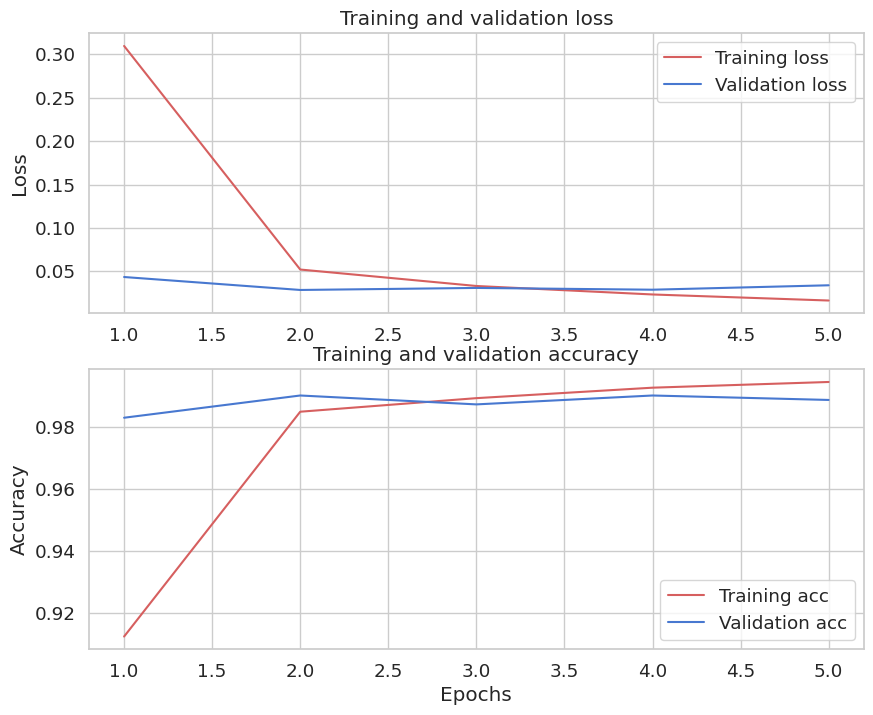

In [34]:
#plotting
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')